# Python Ubertooth Bindings
bla bla bla bla jupyter has no spellcheck so drink when you find spelling errors

https://github.com/hackgnar/pyubertooth

Why not just use the provided CLI C tools and C libs?
* My python implementation sucks and drops a lot of traffic.  Makes it good for low resource devices.
* Easy to deploy
* Good for prototypes
* Access to more functionality than what is provided by CLI without the need to hammer out some C
* Easier to integrate with other libs

### Lib imports
The only one that matters is 

> ```import Ubertooth```

The ````BtbbPacket```` lib is important if you want to decode baseband data off the wire into something other than bits and bytes.  However the current code **sucks ass** and its rewrite is my main objective for revisiting this project

In [1]:
import time
import sys
sys.path.insert(0,"/Users/rholeman/src/pyubertooth")
from pyubertooth.ubertooth import Ubertooth, ubertooth_rx_to_stdout
from pylibbtbb.bluetooth_packet import BtbbPacket
import bluetooth

### Create an ubertooth device to interact with
This supports real and file based devices so you can import a dump file for post mortem analysis or testing

In [2]:
u = Ubertooth()

### Get simple information from the device
all of this is supported from the C CLI tools

In [3]:
print("serial: %s" % u.cmd_get_serial())
print("part number: %s" % u.cmd_get_partnum())
print("board id: %s" % u.cmd_get_board_id())

serial: 131111115f025453-5a099ab340000f5
part number: 0x25011723
board id: 1


### Stream raw data form the device
This allows you to do your own deserialization of the btbb data or whatever you want to do

In [4]:
for data in u.rx_stream(count=5):
    print(data)
u.cmd_stop()

array('B', [0, 24, 39, 0, 160, 82, 178, 169, 230, 186, 0, 18, 0, 0, 97, 64, 96, 228, 122, 12, 96, 126, 200, 99, 1, 149, 208, 165, 221, 28, 109, 182, 10, 224, 46, 184, 135, 143, 13, 32, 199, 119, 90, 106, 100, 113, 160, 49, 235, 175, 48, 160, 132, 112, 230, 0, 143, 253, 201, 188, 112, 190, 190, 86])
array('B', [0, 24, 39, 0, 80, 98, 178, 169, 222, 216, 0, 20, 0, 0, 8, 15, 79, 111, 113, 224, 14, 15, 152, 239, 27, 91, 195, 118, 19, 68, 31, 214, 24, 127, 12, 116, 117, 91, 44, 200, 16, 119, 24, 63, 104, 249, 15, 164, 208, 232, 30, 167, 239, 85, 16, 97, 190, 214, 188, 145, 67, 22, 12, 174])
array('B', [0, 24, 39, 0, 255, 113, 178, 169, 224, 218, 0, 21, 0, 0, 3, 239, 11, 238, 120, 0, 133, 23, 234, 192, 255, 130, 239, 231, 14, 7, 35, 242, 81, 3, 197, 195, 135, 15, 238, 2, 105, 60, 30, 4, 120, 253, 120, 159, 184, 226, 128, 247, 10, 60, 191, 252, 85, 25, 246, 72, 33, 253, 177, 13])
array('B', [0, 24, 39, 0, 158, 129, 178, 169, 225, 218, 255, 20, 0, 0, 230, 31, 181, 58, 203, 144, 110, 3, 151, 61,

### Do the same stuff you can do from CLI but in python
meh... not so impressive, but cool

In [5]:
u.cmd_led_specan()

In [6]:
u.cmd_stop()

### Get & set core functionality on the fly
You can kind of do this from the CLI tools, but this allows you to do shit on the fly without hacks or a C implementation

In [9]:
u.cmd_get_channel()

50

In [8]:
u.cmd_set_channel(50)

### Get & set C only functionality on the fly
You can do this shit from the CLI tools.  

In [38]:
for i in range(10):
    print(u.cmd_get_clock())

5863
5864
5865
5866
5867
5867
5868
5869
5870
5870


In [37]:
u.cmd_set_clock()

### Blink lights like a boss
because it makes us feel like we know how to program hardware

In [39]:
for i in range(10):
    time.sleep(1)
    u.cmd_set_usrled(state=i%2)

KeyboardInterrupt: 

In [40]:
for i in range(100):
    time.sleep(0.1)
    x = u.cmd_get_clock()
    u.cmd_set_usrled(state=x%2)
    x = u.cmd_get_clock()
    u.cmd_set_rxled(state=x%2)
    x = u.cmd_get_clock()
    u.cmd_set_txled(state=x%2)

### Stream and deserialize bluetooth data all in python
We can even add some different spins on this by changing settings while doing live streams.  For example, we can add  channel survey (this wasnt always available in the CLI) with the following:
````
channel = u.cmd_get_channel()
channel += 1
u.cmd_set_channel(channel % 79)
````

In [47]:
results = []
for data in u.rx_stream():
    channel = u.cmd_get_channel()
    channel += 1
    u.cmd_set_channel(channel % 79)    
    pkt = BtbbPacket(data=data)
    if pkt.LAP:
        results.append(pkt)
        print(pkt)
        if len(results) > 10:
            break
u.cmd_stop()

{'LAP': '4c9f75', 'channel': 70}
{'LAP': '0a4eea', 'channel': 74}
{'LAP': 'e6f18d', 'channel': 8}
{'LAP': 'e6f18d', 'channel': 0}
{'LAP': '0a4eea', 'channel': 0}
{'LAP': '0a4eea', 'channel': 8}
{'LAP': '0a4eea', 'channel': 68}
{'LAP': '6f1c8a', 'channel': 35}
{'LAP': '52e388', 'channel': 13}
{'LAP': '52e388', 'channel': 9}
{'LAP': '4c9f75', 'channel': 54}


### Paint a pretty picture
Because managers love this shit

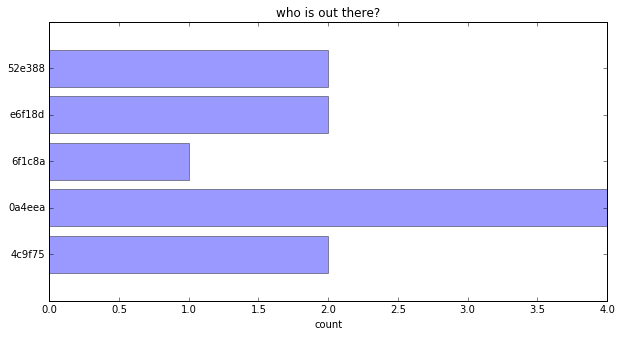

In [49]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

tmp = {}
for i in results:
    if i.LAP in tmp:
        tmp[i.LAP] += 1
    else:
        tmp[i.LAP] = 1
LAPs = tmp.keys()
lap_count = tmp.values()
y_pos = np.arange(len(LAPs))
fig = plt.figure(figsize=(10, 5))
plt.barh(y_pos, lap_count, align='center', alpha=0.4)
plt.yticks(y_pos, LAPs)
plt.xlabel('count')
plt.title('who is out there?')
plt.show()

### Implement hybrid active/passive approaches
**NOTE: dont do this in osx because its python bluetooth support sucks**

In [50]:
u_results = list(set([i.LAP for i in results]))
u_results

['4c9f75', '0a4eea', '6f1c8a', 'e6f18d', '52e388']

In [ ]:
brute_uap = [chr(x).encode("hex") for x in range(256)]
brute_uap
for i in brute_uap:
    address = "0000%s%s" % (i,u_results[0])
    print("trying %s" % address)
    try:
        results = bluetooth.find_service(address=address)
        if results:
            print(results)
            break
    except:
        pass

trying 0000004c9f75
trying 0000014c9f75

/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-00-4c-9f-75: [Errno 4] Error getting services for 00-00-00-4c-9f-75
/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-01-4c-9f-75: [Errno 4] Error getting services for 00-00-01-4c-9f-75



trying 0000024c9f75
trying 0000034c9f75

/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-02-4c-9f-75: [Errno 4] Error getting services for 00-00-02-4c-9f-75
/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-03-4c-9f-75: Timed out getting services for 00-00-03-4c-9f-75



trying 0000044c9f75
trying 0000054c9f75

/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-04-4c-9f-75: Timed out getting services for 00-00-04-4c-9f-75
/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-05-4c-9f-75: Timed out getting services for 00-00-05-4c-9f-75



trying 0000064c9f75
trying 0000074c9f75

/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-06-4c-9f-75: Timed out getting services for 00-00-06-4c-9f-75
/usr/local/lib/python2.7/site-packages/PyBluez-0.22-py2.7.egg/lightblue/_lightblue.py:88: UserWarning: findservices() couldn't get services for 00-00-07-4c-9f-75: Timed out getting services for 00-00-07-4c-9f-75



trying 0000084c9f75

## Upcoming Milestones
* Finish up porting over all command functions (WIP)
* Rewrite my pure python libbtbb lib (WIP)
* Create Ctypes libbtbb bindings (WIP)
* Rewrite my ubertooth scapy rx layer
* Create an ubertooth scapy tx layer
* Possibly port it over to ruby as well (may have already been done)